In [54]:
from bayes_opt import BayesianOptimization, UtilityFunction

import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [55]:
# Prepare data set for demonstration
cancer = load_breast_cancer()
X = cancer["data"]
y = cancer["target"]

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

(569, 30) (569,)
(426, 30) (143, 30) (426,) (143,)


In [56]:
def loss_function(C, X_train_scaled, X_test_scaled, y_train, y_test):
    # objective function to maximize using Bayesian optimization
    model = SVC(C=C)
    model.fit(X_train_scaled, y_train)
    f = roc_auc_score(y_test, model.predict(X_test_scaled))
    return f

# set boundaries of C to optimize
pbounds = {"C": [0.1, 10]}

# create BayesianOptimization object
optimizer = BayesianOptimization(f = None, pbounds = pbounds, 
                                 verbose = 2, random_state = 0)

# set up the parameter acquisition function
utility = UtilityFunction(kind = "ucb", kappa = 1.0, xi = 0.0)  

n_iter = 10
for i in range(n_iter):
    params = optimizer.suggest(utility)
    target = loss_function(**params, 
                           X_train_scaled=X_train_scaled, 
                           X_test_scaled=X_test_scaled, 
                           y_train=y_train, y_test=y_test)
    try:
        optimizer.register(params = params, target = target)
    except:
        pass

print("All iterations:")
for i in range(len(optimizer._space)):
    print("C: {:>5.2f}, roc_auc_score: {:.3f}".format(optimizer._space.params[i][0], optimizer._space.target[i]))

print("Best iteration:")
print("C: {:>5.2f}, roc_auc_score: {:.3f}".format(optimizer.max["params"]["C"], optimizer.max["target"]))

All iterations:
C:  5.53, roc_auc_score: 0.961
C:  0.10, roc_auc_score: 0.927
C:  5.60, roc_auc_score: 0.961
C: 10.00, roc_auc_score: 0.961
C:  7.82, roc_auc_score: 0.961
C:  7.33, roc_auc_score: 0.966
C:  7.67, roc_auc_score: 0.961
C:  6.61, roc_auc_score: 0.961
C:  7.65, roc_auc_score: 0.961
C:  7.46, roc_auc_score: 0.966
Best iteration:
C:  7.33, roc_auc_score: 0.966


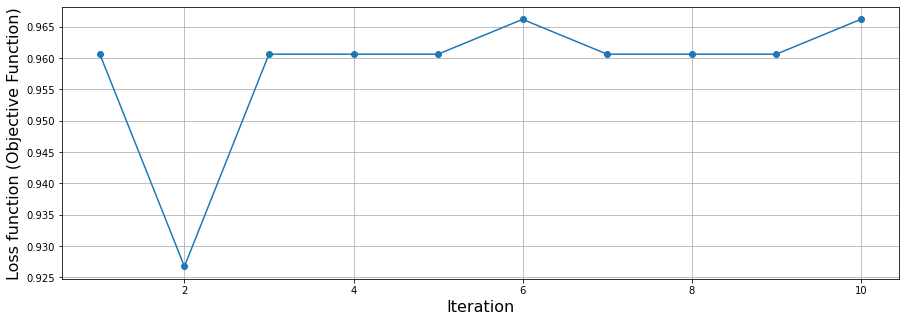

In [57]:
plt.figure(figsize = (15, 5))
plt.plot(range(1,1+len(optimizer._space.target)),optimizer._space.target,"-o")
plt.xlabel("Iteration", fontsize = 16)
plt.ylabel("Loss function (Objective Function)", fontsize = 16)
plt.grid(True)
plt.show()